# Analizing simple statistics features from Lead-1

In [1]:
%load_ext autoreload
%autoreload 2

### Adding imports

Using fastai library, more on https://www.fast.ai/

Repo to the library can be found on https://github.com/fastai/fastai

This Deep Learning library is being used mainly for some handy data processing functions like "proc_df" or "rf_feature_importance".

For more information on those run:

?proc_df

In [3]:
import sys
import os
#sys.path.append("../../tutorials/fastai/old/") # go to parent dir

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy

from xverse.transformer import WOE

#from fastai.imports import *
from structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display

from sklearn import metrics
from sklearn.metrics import f1_score, fbeta_score, make_scorer

import mlflow
import mlflow.sklearn

import plotly.express as px

In [14]:
def print_fscores(m, x, y):
    res = [f1_score(y, m.predict(x), average='weighted'), fbeta_score(y, m.predict(x), beta=2, average='weighted')]
    print(res)

### Path to previously saved data

In [35]:
PATH = "datasets/base"

In [36]:
!ls {PATH}

pyhs-raw  pyhs-raw-corrected


### Loading raw statistics data

In [5]:
lead = 'lead2'
df_raw = pd.read_feather('datasets/corrected/pyhs-raw-lead2-corrected')

In [6]:
labels = pd.get_dummies(df_raw['label'])
labels.describe()

,AF,I-AVB,LBBB,Normal,PAC,PVC,RBBB,STD,STE
count,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000
mean,0.177548,0.104988,0.028937,0.133488,0.079104,0.091173,0.243566,0.114294,0.026901
std,0.382160,0.306560,0.167642,0.340127,0.269921,0.287877,0.429265,0.318191,0.161807
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
df_raw['PT_duration'] = df_raw['mean_T_Offsets'] - df_raw['mean_P_Onsets']
df_raw.drop(['mean_T_Offsets', 'mean_P_Onsets'], axis=1, inplace=True)

## Split between Train and Validation Datasets

In [8]:
from sklearn.model_selection import train_test_split

y = df_raw['label']
X = df_raw.drop('label', axis=1)
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42)

df_train = X_train.copy()
df_eval = X_eval.copy()
df_train.insert(loc=len(X_train.columns), column='label', value=y_train)
df_eval.insert(loc=len(X_eval.columns), column='label', value=y_eval)

In [9]:
X_train, y_train, nas = proc_df(df_train, 'label')
X_eval, y_eval, nas = proc_df(df_eval, 'label', na_dict=nas)

In [10]:
m_af = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, max_features='sqrt', n_jobs=7, oob_score=True)

%time m_af.fit(X_train, y_train)

m_af.score(X_train,y_train), m_af.score(X_eval, y_eval), m_af.oob_score_

CPU times: user 30.2 s, sys: 380 ms, total: 30.6 s
Wall time: 6.35 s


(1.0, 0.5959302325581395, 0.5942555898927467)

In [15]:
print_fscores(m_af, X_eval, y_eval)

[0.5690569710381738, 0.5817799317475856]


## Some feature engineering

### Removing some columns

## Taking a look at Feature Importance

In [17]:
fi = rf_feat_importance(m_af, X_train)

In [18]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

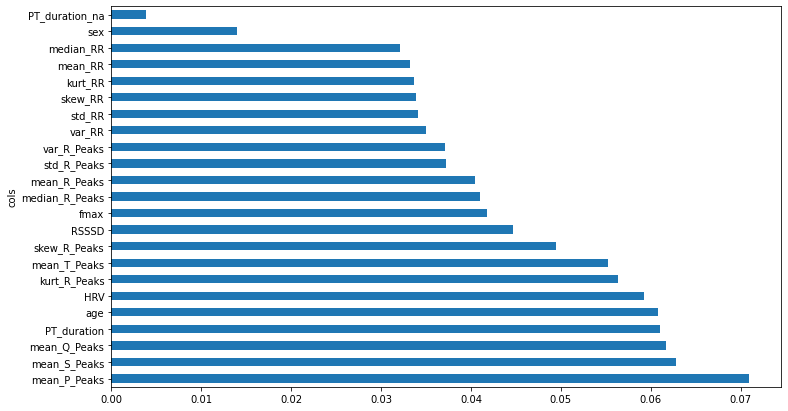

In [19]:
plot_fi(fi[:25]);

In [36]:
thresh = 0.034
to_keep = list(fi[fi['imp'] > thresh].cols)

X_train_keep = X_train[to_keep]
X_eval_keep = X_eval[to_keep]

len(to_keep), to_keep

(17,
 ['mean_P_Peaks',
  'mean_S_Peaks',
  'mean_Q_Peaks',
  'PT_duration',
  'age',
  'HRV',
  'kurt_R_Peaks',
  'mean_T_Peaks',
  'skew_R_Peaks',
  'RSSSD',
  'fmax',
  'median_R_Peaks',
  'mean_R_Peaks',
  'std_R_Peaks',
  'var_R_Peaks',
  'var_RR',
  'std_RR'])

In [37]:
m_af = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, max_features='sqrt', n_jobs=7, oob_score=True)

%time m_af.fit(X_train_keep, y_train)

print_fscores(m_af, X_eval_keep, y_eval)

CPU times: user 32.6 s, sys: 268 ms, total: 32.8 s
Wall time: 6.5 s
[0.570584777269124, 0.5836686888307084]
